### Imports

In [1]:
!pip install pyvww

In [34]:
import pickle
from functools import partial
from sqlite3 import SQLITE_REINDEX
import numpy as np
import matplotlib.pyplot as plt 

import torch 
from torch import device
import torch.nn as nn
import pyvww

from aihwkit.nn import AnalogConv2d, AnalogLinear, AnalogSequential
from aihwkit.optim import AnalogSGD
from aihwkit.simulator.configs import SingleRPUConfig
from aihwkit.simulator.configs.devices import ConstantStepDevice
from aihwkit.simulator.rpu_base import cuda


In [35]:
USE_CUDA = 0
if cuda.is_compiled():
    USE_CUDA = 1
DEVICE = device('cuda' if USE_CUDA else 'cpu')

In [36]:
torch.cuda.is_available()

False

### Dataset: VWW

In [3]:
!git clone https://github.com/Mxbonn/visualwakewords.git

Cloning into 'visualwakewords'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 79 (delta 1), reused 6 (delta 1), pack-reused 71
Unpacking objects: 100% (79/79), 892.43 KiB | 2.62 MiB/s, done.


In [3]:
!bash visualwakewords/scripts/download_mscoco.sh dataset 2014

Skipping download of train2014.zip
Unzipping train2014.zip
train2014/COCO_train2014_000000297665.jpg:  write error (disk full?).  Continue? (y/n/^C) ^C


In [5]:
# Creating COCO Annotation files
!python visualwakewords/scripts/create_coco_train_minival_split.py 

In [8]:
!ls /dccstor/vww_dataset/dataset

all2014  annotations  train2014  val2014


In [9]:
# Creating VWW Annotation files 
MAXITRAIN_ANNOTATIONS_FILE="/dccstor/vww_dataset/dataset/annotations/instances_maxitrain.json"
MINIVAL_ANNOTATIONS_FILE="/dccstor/vww_dataset/dataset/annotations/instances_minival.json"
VWW_OUTPUT_DIR="/dccstor/vww_dataset/visualwakewords-dataset/annotations/"

!python visualwakewords/scripts/create_visualwakewords_annotations.py \
  --train_annotations_file="${MAXITRAIN_ANNOTATIONS_FILE}" \
  --val_annotations_file="${MINIVAL_ANNOTATIONS_FILE}" \
  --output_dir="${VWW_OUTPUT_DIR}" \
  --threshold=0.005 \
  --foreground_class='person'

Processing /dccstor/vww_dataset/dataset/annotations/instances_maxitrain.json...
loading annotations into memory...
Done (t=15.18s)
creating index...
index created!
There are 55233 images that now have label person, of the 115228 images in total.
Processing /dccstor/vww_dataset/dataset/annotations/instances_minival.json...
loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
There are 3800 images that now have label person, of the 8059 images in total.


In [11]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.CenterCrop(100),
    transforms.ToTensor()
])

train_dataset = pyvww.pytorch.VisualWakeWordsClassification(root="/dccstor/vww_dataset/dataset/all2014", 
                    annFile="/dccstor/vww_dataset/dataset/visualwakewords-dataset/annotations/instances_train.json", transform= transform) 
valid_dataset = pyvww.pytorch.VisualWakeWordsClassification(root="/dccstor/vww_dataset/dataset/all2014", 
                    annFile="/dccstor/vww_dataset/dataset/visualwakewords-dataset/annotations/instances_val.json", transform= transform)

loading annotations into memory...
Done (t=3.45s)
creating index...
index created!
loading annotations into memory...
Done (t=0.20s)
creating index...
index created!


In [12]:
img, target = train_dataset[5]
display(target)
display(img)

1

tensor([[[0.9882, 0.9294, 0.9843,  ..., 0.5804, 0.4784, 0.4627],
         [0.6980, 0.4588, 0.7333,  ..., 0.6941, 0.6745, 0.6275],
         [0.6078, 0.4039, 0.4667,  ..., 0.9373, 0.8510, 0.5451],
         ...,
         [0.6196, 0.5137, 0.6824,  ..., 0.3333, 0.6627, 0.4039],
         [0.6078, 0.3647, 0.5412,  ..., 0.1647, 0.0000, 0.0549],
         [0.2549, 0.0471, 0.4314,  ..., 0.6392, 0.2118, 0.2157]],

        [[1.0000, 0.9333, 0.9843,  ..., 0.6118, 0.5137, 0.5137],
         [0.7490, 0.4941, 0.7608,  ..., 0.7216, 0.6784, 0.6392],
         [0.6902, 0.4824, 0.5373,  ..., 0.9294, 0.8471, 0.5529],
         ...,
         [0.6000, 0.5020, 0.6824,  ..., 0.3725, 0.7373, 0.4275],
         [0.5961, 0.3529, 0.5490,  ..., 0.2392, 0.0118, 0.1216],
         [0.2510, 0.0549, 0.4510,  ..., 0.6980, 0.2157, 0.2392]],

        [[1.0000, 0.9529, 0.9922,  ..., 0.6235, 0.5490, 0.5451],
         [0.6392, 0.4118, 0.6980,  ..., 0.7922, 0.7882, 0.6588],
         [0.5216, 0.2902, 0.3490,  ..., 0.9804, 0.8706, 0.

TypeError: Invalid shape (3, 100, 100) for image data

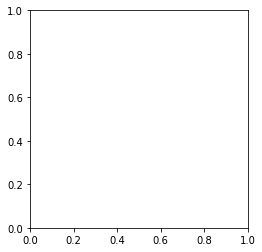

In [13]:
img_id = train_dataset.ids[5]
ann_ids = train_dataset.vww.getAnnIds(imgIds=img_id)
full_target = train_dataset.vww.loadAnns(ann_ids)
plt.imshow(img)
train_dataset.vww.showAnns(full_target)

In [14]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=0)

In [15]:
RPU_CONFIG = SingleRPUConfig(device=ConstantStepDevice())

### Model Definition 

In [16]:
import math
from typing import List, Tuple
import torch.nn.functional as F
# Calculate asymmetric TensorFlow-like 'SAME' padding for a convolution
def get_same_padding(x: int, k: int, s: int, d: int):
    return max((math.ceil(x / s) - 1) * s + (k - 1) * d + 1 - x, 0)

# Dynamically pad input x with 'SAME' padding for conv with specified args
def pad_same(x, k: List[int], s: List[int], d: List[int] = 1, value: float = 0):
    ih, iw = x.size()[-2:]
    pad_h, pad_w = get_same_padding(ih, k, s, d), get_same_padding(iw, k, s, d)
    if pad_h > 0 or pad_w > 0:
        x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2], value=value)
    return x

In [17]:
class ConvBNAct(nn.Sequential):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        kernel_size: int,
        stride: int,
        padding: int = None,
        norm: nn.Module = nn.BatchNorm2d,
        act: nn.Module = nn.ReLU, 
        rpu_config = RPU_CONFIG,
    ):
        if padding: 
            super().__init__(
                AnalogConv2d(
                    in_features,
                    out_features,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding= padding,
                    rpu_config=RPU_CONFIG
                ),
                norm(out_features),
                act(inplace=False),
            )
        else: 
            super().__init__(
                AnalogConv2d(
                    in_features,
                    out_features,
                    kernel_size=kernel_size,
                    stride=stride,
                    rpu_config=RPU_CONFIG
                ),
                norm(out_features),
                act(inplace=False),
            )
        
Conv1X1BnReLU = partial(ConvBNAct, kernel_size=1, stride=2)
Conv3X3BnReLU = partial(ConvBNAct, kernel_size=3, stride=2)

In [18]:
class fused_MBConv(nn.Module):
    def __init__(self, in_features: int, out_features: int, stride: int, expansion: int, residual = True):
        #expanded_features = in_features * expansion
        super().__init__()
        #padding = get_same_padding()
        self.stride = stride
        self.block = nn.Sequential(
                    nn.Sequential(
                        # wide -> wide
                        Conv3X3BnReLU(in_features, 
                                      expansion, 
                                      stride= stride,
                                      act=nn.ReLU
                                     ),
                        # wide -> narrow-
                        Conv1X1BnReLU(expansion, out_features, stride=1,padding=1, act=nn.Identity),
                    ),
                nn.ReLU(inplace=False),
            )
        self.residual = residual
        
    def forward(self, x): 
        x = pad_same(x, 3, self.stride)
        x1 = self.block(x)
        if self.residual: 
            x1 = x1 + x.clone() 
        return x1

In [19]:
torch.__version__

'1.8.1+cu102'

In [20]:
class AnalogNetVWW(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = ConvBNAct(3,12,3,2,1)
        self.blocks = []
        
        # Each block is defined by the in/out channels, expansion, residual and stride
        input_channels = [12,24,24,28,28,28,24,24,24,23,16,28,28,16,16,32]
        expansion = [28,28,128,152,152,152,112,112,76,76,56,56,56,96,96,128]
        residuals = [False, True, False, True, True, False, True, True, False, False, False, False, False, False, False]
        stride = [2,1,2,1,1,2,1,1,1,1,1,1,2,1,1]
        
        self.nb_blocks = 15
        for i in range(self.nb_blocks):
            self.blocks.append(fused_MBConv(input_channels[i],input_channels[i+1], stride[i], 
                                            expansion[i], residuals[i]))
        
        self.blocks = nn.Sequential(*self.blocks)
        self.pool = nn.AvgPool2d(3, stride=1)
        self.linear = nn.Linear(9248, 2)
        
    def forward(self, x): 
        x = self.layer1(x)
        x = self.blocks(x)
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        return torch.softmax(self.linear(x), 1)

In [21]:
model = AnalogNetVWW()

In [22]:
model

AnalogNetVWW(
  (layer1): ConvBNAct(
    (0): AnalogConv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), digital bias)
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (blocks): Sequential(
    (0): fused_MBConv(
      (block): Sequential(
        (0): Sequential(
          (0): ConvBNAct(
            (0): AnalogConv2d(12, 28, kernel_size=(3, 3), stride=(2, 2), digital bias)
            (1): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
          (1): ConvBNAct(
            (0): AnalogConv2d(28, 24, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1), digital bias)
            (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): Identity()
          )
        )
        (1): ReLU()
      )
    )
    (1): fused_MBConv(
      (block): Sequential(
        (0): Sequential(
          (0): ConvBNAct(
    

In [23]:
# test model 
dummy_input = torch.randn([1, 3, 100, 100])
model.eval()
np_torch_out = model(dummy_input).data.numpy()
print(np_torch_out)

[[0.49781778 0.50218225]]


### Training

In [24]:
# Training parameters
SEED = 1
N_EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 0.1
N_CLASSES = 2
WEIGHT_SCALING_OMEGA = 0.6  # Should not be larger than max weight.

In [25]:
def create_sgd_optimizer(model, learning_rate):
    """Create the analog-aware optimizer.

    Args:
        model (nn.Module): model to be trained
        learning_rate (float): global parameter to define learning rate
    Returns:
        Optimizer: optimizer
    """
    optimizer = AnalogSGD(model.parameters(), lr=learning_rate)
    optimizer.regroup_param_groups(model)

    return optimizer


In [26]:

def train_step(train_data, model, criterion, optimizer):
    """Train network.

    Args:
        train_data (DataLoader): Validation set to perform the evaluation
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss
        optimizer (Optimizer): analog model optimizer

    Returns:
        nn.Module, Optimizer, float: model, optimizer, and epoch loss
    """
    total_loss = 0

    model.train()

    for images, labels in train_data:
        print("START")
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        # Add training Tensor to the model (input).
        output = model(images)
        loss = criterion(output, labels)

        # Run training (backward propagation).
        loss.backward()

        # Optimize weights.
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        print(total_loss)
    epoch_loss = total_loss / len(train_data.dataset)

    return model, optimizer, epoch_loss


def test_evaluation(validation_data, model, criterion):
    """Test trained network

    Args:
        validation_data (DataLoader): Validation set to perform the evaluation
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss

    Returns:
        nn.Module, float, float, float: model, test epoch loss, test error, and test accuracy
    """
    total_loss = 0
    predicted_ok = 0
    total_images = 0

    model.eval()

    for images, labels in validation_data:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        pred = model(images)
        loss = criterion(pred, labels)
        total_loss += loss.item() * images.size(0)

        _, predicted = torch_max(pred.data, 1)
        total_images += labels.size(0)
        predicted_ok += (predicted == labels).sum().item()
        accuracy = predicted_ok/total_images*100
        error = (1-predicted_ok/total_images)*100

    epoch_loss = total_loss / len(validation_data.dataset)

    return model, epoch_loss, error, accuracy


In [27]:
def training_loop(model, criterion, optimizer, train_data, validation_data, epochs, print_every=1):
    train_losses = []
    valid_losses = []
    test_error = []

    # Train model
    for epoch in range(0, epochs):
        # Train_step
        torch.autograd.set_detect_anomaly(True)
        model, optimizer, train_loss = train_step(train_data, model, criterion, optimizer)
        train_losses.append(train_loss)

        if epoch % print_every == (print_every - 1):
            # Validate_step
            with no_grad():
                model, valid_loss, error, accuracy = test_evaluation(
                    validation_data, model, criterion)
                valid_losses.append(valid_loss)
                test_error.append(error)

            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Test error: {error:.2f}%\t'
                  f'Test accuracy: {accuracy:.2f}%\t')

    # Save results and plot figures
    np.savetxt(os.path.join(RESULTS, "Test_error.csv"), test_error, delimiter=",")
    np.savetxt(os.path.join(RESULTS, "Train_Losses.csv"), train_losses, delimiter=",")
    np.savetxt(os.path.join(RESULTS, "Valid_Losses.csv"), valid_losses, delimiter=",")
    plot_results(train_losses, valid_losses, test_error)

    return model, optimizer, (train_losses, valid_losses, test_error)


In [28]:
def plot_results(train_losses, valid_losses, test_error):
    """Plot results.

    Args:
        train_losses (List): training losses as calculated in the training_loop
        valid_losses (List): validation losses as calculated in the training_loop
        test_error (List): test error as calculated in the training_loop
    """
    fig = plt.plot(train_losses, 'r-s', valid_losses, 'b-o')
    plt.title('aihwkit  AnalogNet-VWW')
    plt.legend(fig[:2], ['Training Losses', 'Validation Losses'])
    plt.xlabel('Epoch number')
    plt.ylabel('Loss [A.U.]')
    plt.grid(which='both', linestyle='--')
    plt.savefig(os.path.join(RESULTS, 'test_losses.png'))
    plt.close()

    fig = plt.plot(test_error, 'r-s')
    plt.title('aihwkit AnalogNet-VWW')
    plt.legend(fig[:1], ['Test Error'])
    plt.xlabel('Epoch number')
    plt.ylabel('Test Error [%]')
    plt.yscale('log')
    plt.ylim((5e-1, 1e2))
    plt.grid(which='both', linestyle='--')
    plt.savefig(os.path.join(RESULTS, 'test_error.png'))
    plt.close()

In [29]:
optimizer = create_sgd_optimizer(model, LEARNING_RATE)

criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader,
                                    N_EPOCHS)

print(f'{datetime.now().time().replace(microsecond=0)} --- '
          f'Completed AnalogNet-VWW')

START
22.509504318237305
START
47.53272819519043
START
72.53085899353027
START
94.53685188293457
START
126.50631713867188
START
149.51226043701172
START
174.51644134521484
START
200.5413360595703
START
225.5609474182129
START
249.57230186462402
START
278.5701732635498
START
299.58553886413574
START
327.6038761138916
START
352.53384590148926
START
376.5626411437988
START
406.5526885986328
START
431.5181827545166
START
455.5213985443115
START
480.42695236206055
START
512.3888607025146
START
537.2624530792236
START
563.0433769226074
START
582.8069667816162
START
607.1594066619873
START
637.0866088867188
START
662.9751415252686
START
687.8255271911621
START


KeyboardInterrupt: 